# get my data here
https://drive.google.com/drive/folders/1s0_kPLkJ5ueCYbr4-Ddqp5VcRXWdqnbv?usp=sharing

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.ndimage import convolve as conv
import concurrent.futures
from matplotlib.patches import ConnectionPatch
from scipy.spatial import cKDTree
from scipy.spatial.distance import cdist
from sklearn.metrics import pairwise_distances_argmin_min
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation


In [2]:
def extract_frames(path_to_vid):
    parent_dir = os.path.dirname(path_to_vid)

    num_pngs = len([f for f in os.listdir(parent_dir) if f.endswith('.png')])
    if num_pngs > 0:
        print('Frames already extracted')
        return

    # extract every 10 using ffmpeg
    cmd = "ffmpeg -i {} -vf \"select=not(mod(n\,5))\" -vsync vfr {}_frame_%04d.png"
    os.system(cmd.format(path_to_vid, parent_dir + '/frames'))


In [3]:
extract_frames("./data/calibration/vid/cal.mov")

ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 14.0.0 (clang-1400.0.29.202)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/5.1.2_6 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --

In [4]:
# read a frame and print its resolution
img = cv2.imread("./data/imgs/vending/frames_frame_0001.png")
print(img.shape)

(1920, 1080, 3)


In [5]:
def generate_gaussian_kernel(size, sigma):
    kernel = np.zeros((size, size))
    center = size // 2
    for i in range(size):
        for j in range(size):
            x, y = i - center, j - center
            kernel[i, j] = np.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2))
    return np.array(kernel / np.sum(kernel))

In [6]:
def downscale(img):
    """
    use gaussian filter to downscale the image by 2
    """
    kernel = generate_gaussian_kernel(5, 1.4)
    return conv(img, kernel, mode='nearest')[::2, ::2]
    

In [7]:
def calibrate_camera(images, pattern_size, square_size):
    print("Calibrating camera...")
    print("Processing {} images...".format(len(images)))
    
    objp = np.zeros((np.prod(pattern_size), 3), np.float32)
    objp[:, :2] = np.indices(pattern_size).T.reshape(-1, 2)
    objp *= square_size

    objpoints = []
    imgpoints = []

    termination_criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    for img_path in images:
        print("Processing image: {}".format(img_path))

        img = cv2.imread(img_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, pattern_size, None)

        if ret:
            print("Chessboard corners found.")
            corners = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), termination_criteria)
            objpoints.append(objp)
            imgpoints.append(corners)

            img = cv2.drawChessboardCorners(img, pattern_size, corners, ret)
            plt.imshow(img)
            plt.show()

        else:
            print("Chessboard corners NOT found.")

    ret, camera_matrix, dist_coeffs, r_vecs, t_vecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    if not ret:
        raise Exception("Camera calibration failed. Please make sure your input images have a clear and consistent pattern.")

    return camera_matrix, dist_coeffs, objpoints, imgpoints, r_vecs, t_vecs

In [8]:
def generate_chessboard_image(pattern_size, square_size):
    """returns a chessboard calibration image

    Args:
        pattern_size (tuple): how many squares in each direction (rows, columns)
        square_size (int): the size of a square in mm

    Returns:
        numpy.ndarray: chessboard calibration image
    """

    # Convert mm to pixels (assuming 300 DPI)
    dpi = 72
    mm_to_pixels = dpi / 25.4
    square_size_pixels = int(square_size * mm_to_pixels)

    # Calculate the image size
    image_width = pattern_size[1] * square_size_pixels
    image_height = pattern_size[0] * square_size_pixels

    # Create a new image
    image = np.ones((image_height, image_width), dtype=np.uint8) * 255

    # Draw the chessboard pattern
    for i in range(pattern_size[0]):
        for j in range(pattern_size[1]):
            if (i + j) % 2 == 0:
                image[i * square_size_pixels:(i + 1) * square_size_pixels,
                      j * square_size_pixels:(j + 1) * square_size_pixels] = 0

    return image

chessboard_image = generate_chessboard_image((8, 8), 30)
cv2.imwrite("chessboard_calibration_image.png", chessboard_image)

True

In [9]:
def verify(intrinsics, objpoints, imgpoints, pattern_size, square_size, images, r_vecs, t_vecs, dist_coeffs):
    print("Verifying intrinsic matrix...")

    total_error = 0
    total_points = 0

    for objp, imgp, img_path, r, t in zip(objpoints, imgpoints, images, r_vecs, t_vecs):
        img = cv2.imread(img_path)
        img_vis = img.copy()

        # Project 3D object points back onto the image plane using the camera matrix
        imgp_reprojected, _ = cv2.projectPoints(objp, r, t, intrinsics, dist_coeffs)

        # Ensure the reprojected points have the same data type and shape as the original points
        imgp_reprojected = imgp_reprojected.reshape(-1, 1, 2).astype(imgp.dtype)

        # Calculate the Euclidean distance between the original and reprojected points
        error = cv2.norm(imgp, imgp_reprojected, cv2.NORM_L2) / len(imgp)

        total_error += error
        total_points += len(objp)

        # points to int
        imgp = imgp.astype(int)
        imgp_reprojected = imgp_reprojected.astype(int)

        # Draw original image points (red circles) and reprojected points (green crosses) on the image
        for p1, p2 in zip(imgp, imgp_reprojected):
            img_vis = cv2.circle(img_vis, tuple(p1[0]), 5, (0, 0, 255), -1)
            img_vis = cv2.drawMarker(img_vis, tuple(p2[0]), (0, 255, 0), cv2.MARKER_CROSS, 25, 2)

        plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
        plt.show()

    mean_error = total_error / total_points

    print("Mean reprojection error: {:.4f} pixels".format(mean_error))

    return mean_error

In [10]:
calibration_images = [os.path.join("data/calibration/vid", f) for f in os.listdir("data/calibration/vid") if f.endswith(".png") or f.endswith(".jpg")]

pattern_size = (7, 7)
square_size = 30

Calibrating camera...
Processing 21 images...
Processing image: data/calibration/vid/frames_frame_0021.png
Chessboard corners found.


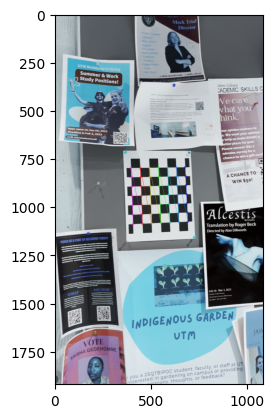

Processing image: data/calibration/vid/frames_frame_0009.png
Chessboard corners found.


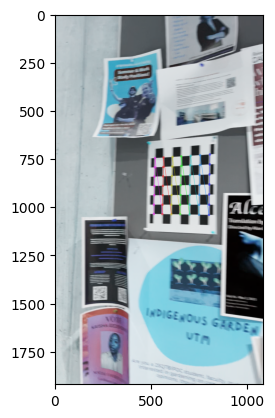

Processing image: data/calibration/vid/frames_frame_0008.png
Chessboard corners found.


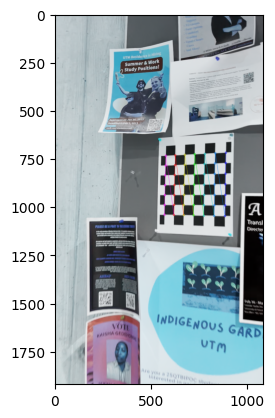

Processing image: data/calibration/vid/frames_frame_0020.png
Chessboard corners found.


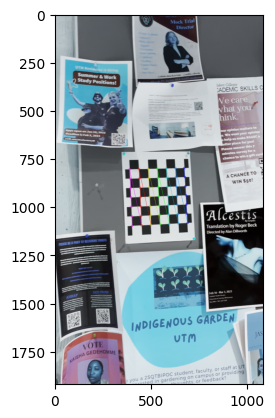

Processing image: data/calibration/vid/frames_frame_0018.png
Chessboard corners found.


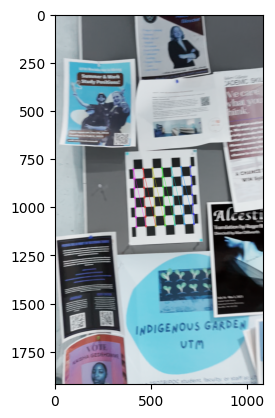

Processing image: data/calibration/vid/frames_frame_0019.png
Chessboard corners found.


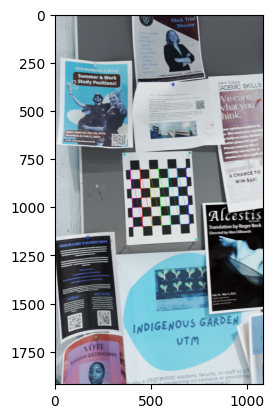

Processing image: data/calibration/vid/frames_frame_0014.png
Chessboard corners found.


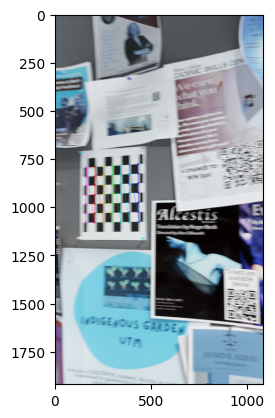

Processing image: data/calibration/vid/frames_frame_0015.png
Chessboard corners found.


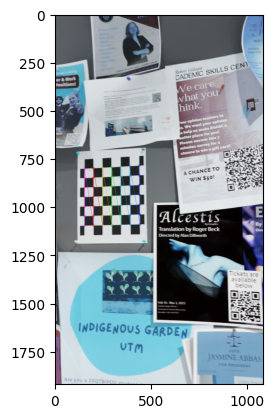

Processing image: data/calibration/vid/frames_frame_0001.png
Chessboard corners found.


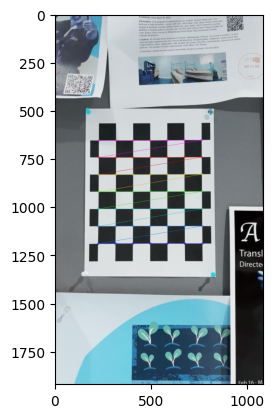

Processing image: data/calibration/vid/frames_frame_0017.png
Chessboard corners found.


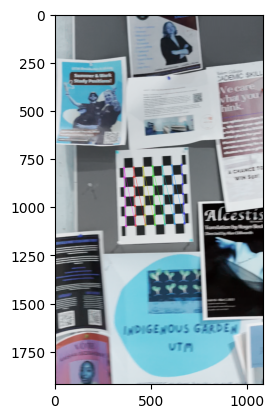

Processing image: data/calibration/vid/frames_frame_0003.png
Chessboard corners found.


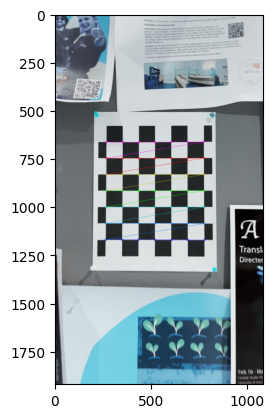

Processing image: data/calibration/vid/frames_frame_0002.png
Chessboard corners found.


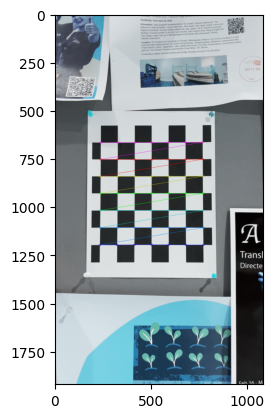

Processing image: data/calibration/vid/frames_frame_0016.png
Chessboard corners found.


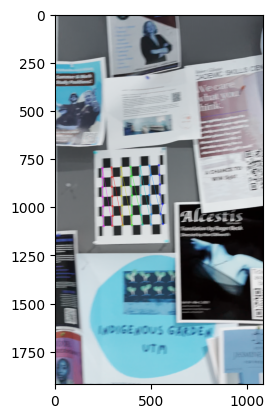

Processing image: data/calibration/vid/frames_frame_0012.png
Chessboard corners found.


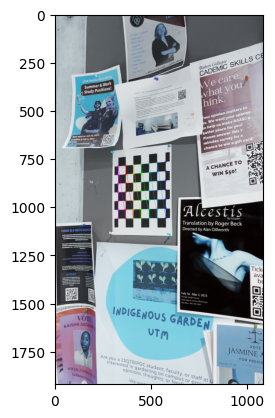

Processing image: data/calibration/vid/frames_frame_0006.png
Chessboard corners found.


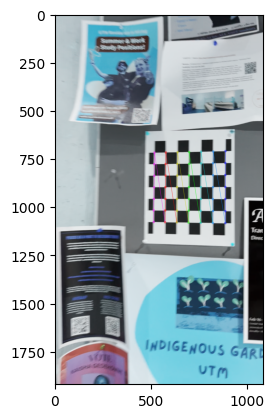

Processing image: data/calibration/vid/frames_frame_0007.png
Chessboard corners found.


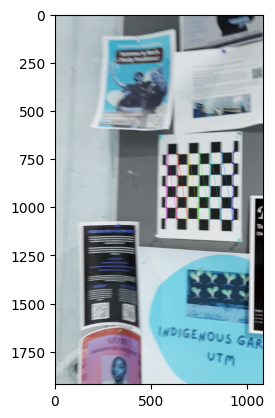

Processing image: data/calibration/vid/frames_frame_0013.png
Chessboard corners found.


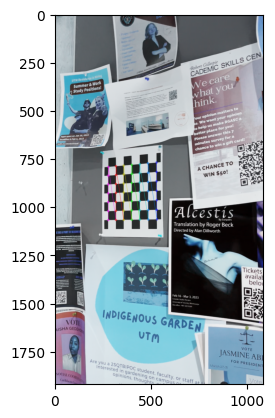

Processing image: data/calibration/vid/frames_frame_0005.png
Chessboard corners found.


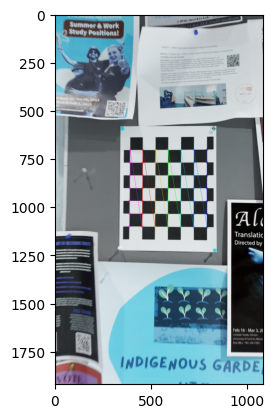

Processing image: data/calibration/vid/frames_frame_0011.png
Chessboard corners found.


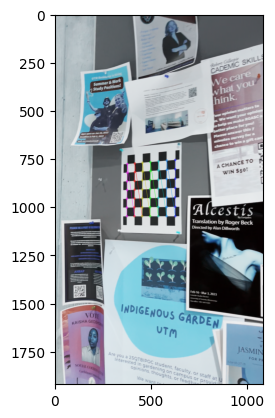

Processing image: data/calibration/vid/frames_frame_0010.png
Chessboard corners found.


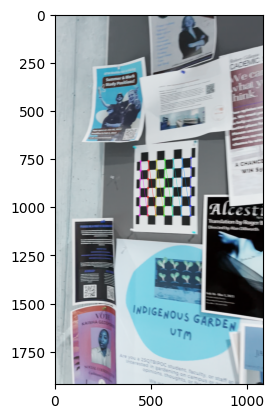

Processing image: data/calibration/vid/frames_frame_0004.png
Chessboard corners found.


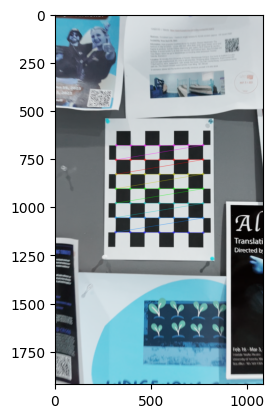

Intrinsic matrix:
 [[1.66556064e+03 0.00000000e+00 5.58876601e+02]
 [0.00000000e+00 1.66646957e+03 9.37922448e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Verifying intrinsic matrix...


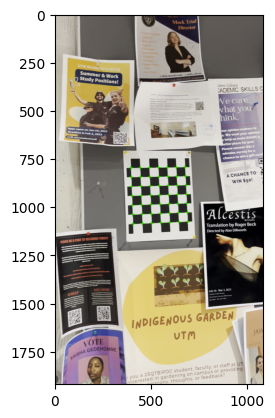

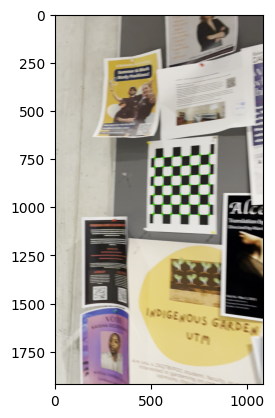

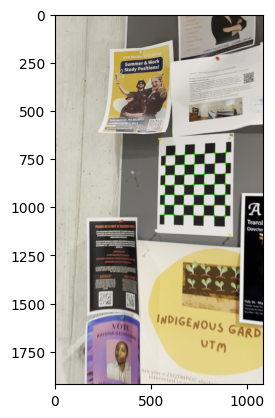

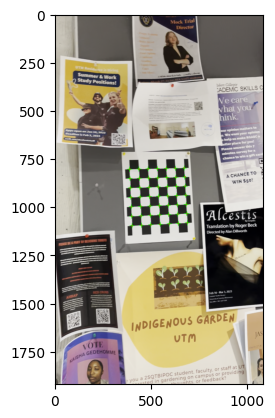

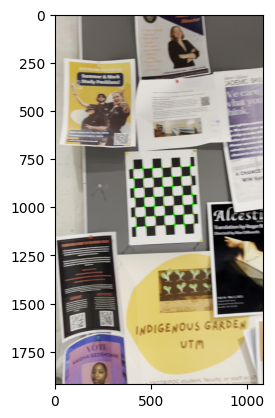

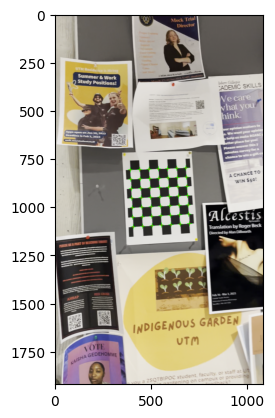

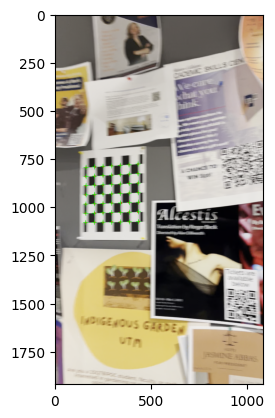

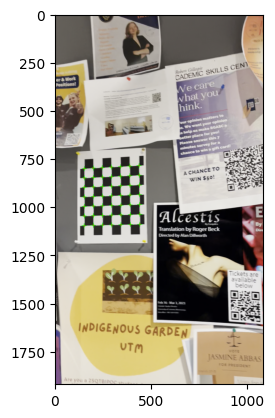

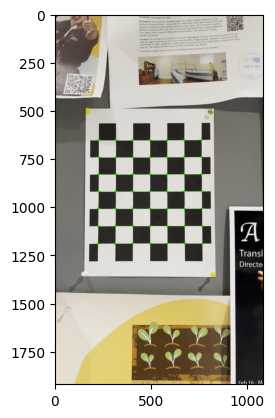

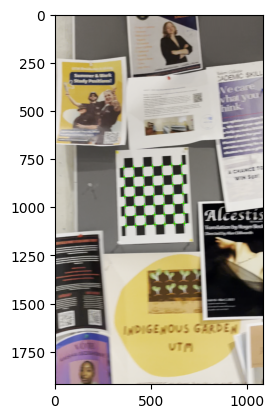

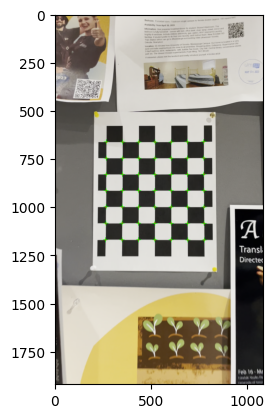

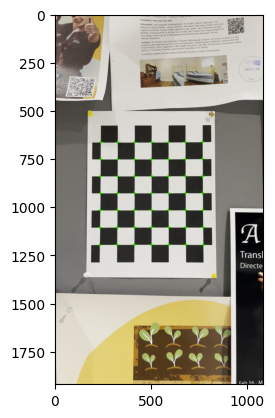

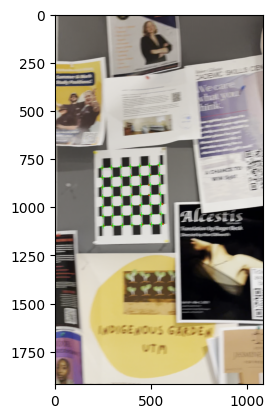

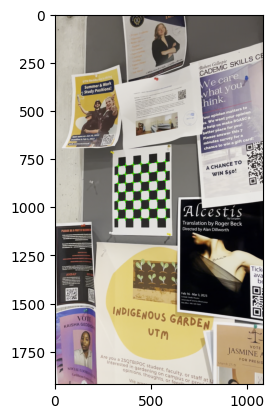

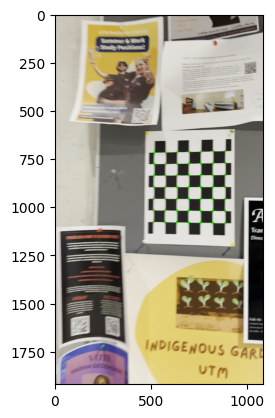

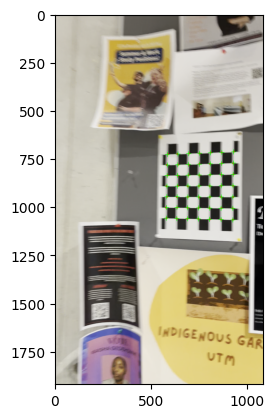

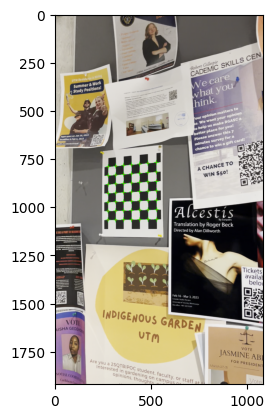

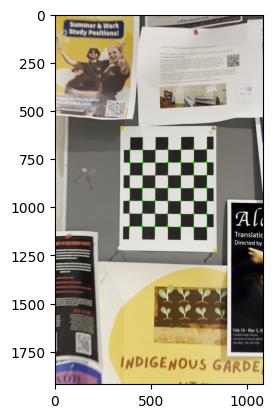

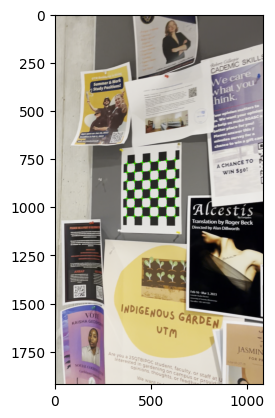

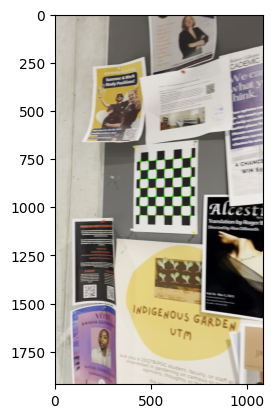

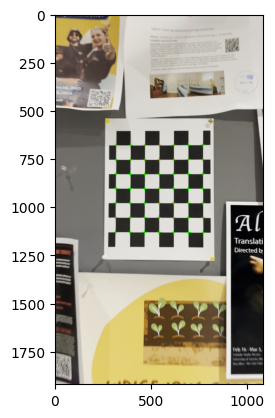

Mean reprojection error: 0.0013 pixels


0.0013303598888598587

In [11]:
intrinsics, dist_coeffs, objpoints, imgpoints, r_vecs, t_vecs = calibrate_camera(calibration_images, pattern_size, square_size)
print("Intrinsic matrix:\n", intrinsics)
verify(intrinsics, objpoints, imgpoints, pattern_size, square_size, calibration_images, r_vecs, t_vecs, dist_coeffs)

In [12]:
def compute_homography(src_pts, dest_pts):
    num_points = src_pts.shape[0]
    A = np.zeros((2 * num_points, 9))

    for i in range(num_points):
        x1, y1 = src_pts[i]
        x2, y2 = dest_pts[i]

        A[2 * i] = [-x1, -y1, -1, 0, 0, 0, x2 * x1, x2 * y1, x2]
        A[2 * i + 1] = [0, 0, 0, -x1, -y1, -1, y2 * x1, y2 * y1, y2]

    _, _, Vt = np.linalg.svd(A)
    H = Vt[-1].reshape(3, 3)

    return H

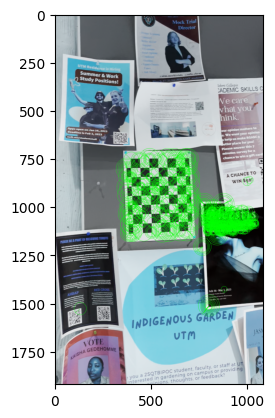

In [13]:
def extract_keypoints(image_path):
    img = cv2.imread(image_path)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    orb = cv2.ORB_create(nfeatures=750)
    kp, des = orb.detectAndCompute(gray_img, None)

    return kp, des

def visualize_match(img_path):
    kp, _ = extract_keypoints(img_path)
    img = cv2.imread(img_path)
    kp_img = cv2.drawKeypoints(img, kp, None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(kp_img)
    plt.show()

visualize_match(calibration_images[0])

In [14]:
def compute_matches(src_kp, src_desc, dest_kp, dest_desc, src_img, dest_img, i=None, j=None):
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(src_desc, dest_desc)
    matches = sorted(matches, key=lambda x: x.distance)

    # want to keep only the good matches and return the matching keypoints
    good_matches = []
    src_pts = []
    dest_pts = []

    for m in matches:
        if m.distance < 75:
            good_matches.append(m)
            src_pts.append(src_kp[m.queryIdx].pt)
            dest_pts.append(dest_kp[m.trainIdx].pt)

    # draw first 10 matches
    match_img = cv2.cvtColor(cv2.drawMatches(src_img, src_kp, dest_img, dest_kp, good_matches[:50], None, flags=2), cv2.COLOR_BGR2RGB)
    if i is not None and j is not None:
        plt.title("Matches between image {} and image {}".format(i, j))
    plt.imshow(match_img)
    plt.show()
    


    return good_matches, np.array(src_pts), np.array(dest_pts)

In [15]:
def load_and_compute_keypoints(image_paths):
    keypoints_list = []
    descriptors_list = []

    for image_path in image_paths:
        src_kps, src_descs = extract_keypoints(image_path)
        keypoints_list.append(src_kps)
        descriptors_list.append(src_descs)

    return keypoints_list, descriptors_list

def compute_fundamental_matrix(keypoints1, keypoints2):
    pts1_normalized = keypoints1 / np.max(keypoints1)
    pts2_normalized = keypoints2 / np.max(keypoints2)
    F, _ = cv2.findFundamentalMat(pts1_normalized, pts2_normalized, cv2.FM_8POINT)
    return F

def compute_essential_matrix(F, K):
    return np.dot(K.T, np.dot(F, K))

def decompose_essential_matrix(E):
    U, S, Vt = np.linalg.svd(E)

    W = np.array([[0, -1, 0],
                  [1, 0, 0],
                  [0, 0, 1]])

    R1 = np.dot(U, np.dot(W, Vt))
    R2 = np.dot(U, np.dot(W.T, Vt))

    t1 = U[:, 2]
    t2 = -U[:, 2]

    return [R1, R2], [t1, t2]

def triangulate_points(P1, P2, pts1, pts2):
    points_3D = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)
    points_3D /= points_3D[3]
    return points_3D[:3]

def check_cheirality(R, t, K, keypoints1, keypoints2):
    P1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
    P2 = K @ np.hstack((R, t.reshape(3, 1)))
    
    points_3D = triangulate_points(P1, P2, keypoints1, keypoints2)
    if np.sum(points_3D[2] > 0) > 0.75 * points_3D.shape[1]:
        return True
    return False

def compute_extrinsic_matrix_manual(keypoints1, keypoints2, K):
    keypoints1 = np.float32(keypoints1)
    keypoints2 = np.float32(keypoints2)
    
    F = compute_fundamental_matrix(keypoints1, keypoints2)
    print("Fundamental matrix:\n{}".format(F))
    E = compute_essential_matrix(F, K)
    print("Essential matrix:\n{}".format(E))
    Rs, ts = decompose_essential_matrix(E)
    
    for R, t in zip(Rs, ts):
        if check_cheirality(R, t, K, keypoints1, keypoints2):
            print("Found a valid extrinsic matrix")
            return R, t
    print("Could not find a valid extrinsic matrix")
    return None, None

def compute_extrinsic_matrix(keypoints1, keypoints2, K):
    # Compute the fundamental matrix
    F, _ = cv2.findFundamentalMat(keypoints1, keypoints2, cv2.FM_8POINT)

    # Compute the essential matrix
    E = np.dot(K.T, np.dot(F, K))

    # Decompose the essential matrix into rotation and translation
    ret, R, t, mask = cv2.recoverPose(E, keypoints1, keypoints2, K)

    # Combine the rotation and translation components into the extrinsic matrix
    return R, t


done sift


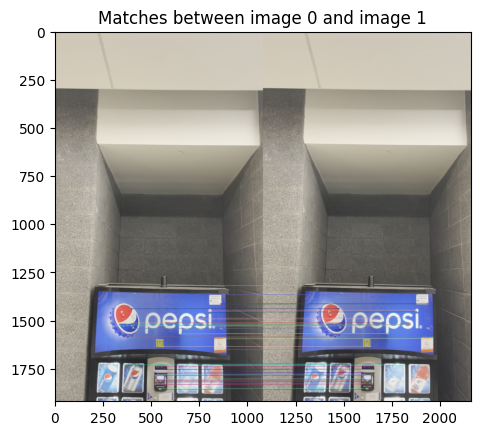

done matches


In [16]:
test_images = sorted([os.path.join("data/imgs/vending", f) for f in os.listdir("data/imgs/vending") if f.endswith(".jpg") or f.endswith(".png")])

keypoints_list, descriptors_list = load_and_compute_keypoints(test_images)
print("done sift")
n = 0
matches, src_pts, dest_pts = compute_matches(keypoints_list[n], descriptors_list[n], keypoints_list[n+1], descriptors_list[n+1], cv2.imread(test_images[n]), cv2.imread(test_images[n+1]), n, n+1)
print("done matches")

In [17]:
def concatenate_transformations(R_prev, t_prev, R_curr, t_curr):
    if R_prev is None or t_prev is None:
        return R_curr, t_curr
    R_new = np.dot(R_prev, R_curr)
    t_new = np.dot(R_prev, t_curr.reshape(3, 1)) + t_prev.reshape(3, 1)

    return R_new, t_new

def create_pose_matrix(R, t):
    t = t.reshape(3, 1)
    pose_matrix_3x4 = np.hstack((R, t))

    pose_matrix = np.vstack((pose_matrix_3x4, [0, 0, 0, 1]))

    return pose_matrix

def deconstruct_pose_matrix(pose_matrix):
    R = pose_matrix[:3, :3]
    t = pose_matrix[:3, 3]

    return R, t

In [18]:
def calculate_poses(images, keypoints_list, intrinsic_matrix):
    poses = {}

    for idx, (image, keypoints) in enumerate(zip(images, keypoints_list)):
        # Convert the keypoints to a list of 2D points
        points2d = np.array([kp.pt for kp in keypoints], dtype=np.float32)

         # Check if there are at least 6 points

        # Convert the 2D points to homogeneous coordinates
        points2d_homogeneous = cv2.convertPointsToHomogeneous(points2d)

        # Reshape points2d_homogeneous for matrix multiplication
        points2d_homogeneous = points2d_homogeneous.reshape(-1, 3)

        # Normalize the points using the intrinsic matrix
        normalized_points = np.matmul(np.linalg.inv(intrinsic_matrix), points2d_homogeneous.T).T

        # Estimate the extrinsic matrix (you may use other methods here depending on your problem)
        # In this example, we will use a dummy 3D points array
        points3d = np.random.rand(len(points2d), 3).astype(np.float32)

        if len(points2d) < 8 or len(points3d) < 8:
            print(f"Skipping image {idx} because it has fewer than 6 points")
            continue

        # Note: You need to replace the above points3d with actual 3D points or use a method
        # to obtain 3D points from 2D points if required.
        ret, rvec, tvec = cv2.solvePnP(points3d, points2d, intrinsic_matrix, None)

        # Convert the rotation vector to a rotation matrix
        rotation_matrix, _ = cv2.Rodrigues(rvec)

        assert rotation_matrix.shape == (3, 3)
        assert tvec.shape == (3, 1)

        pose = create_pose_matrix(rotation_matrix, tvec)

        poses[idx] = pose

    return poses

In [19]:
test_images = sorted([os.path.join("data/imgs/vending", f) for f in os.listdir("data/imgs/vending") if f.endswith(".jpg") or f.endswith(".png")])

keypoints_list, descriptors_list = load_and_compute_keypoints(test_images)

poses = calculate_poses(test_images, keypoints_list, intrinsics)

In [20]:
# normalize the poses to the first pose so they are all relative to the first pose
first_pose = poses[0]
first_R, first_t = deconstruct_pose_matrix(first_pose)

for idx, pose in poses.items():
    R, t = deconstruct_pose_matrix(pose)
    R_new, t_new = concatenate_transformations(first_R, first_t, R, t)
    poses[idx] = create_pose_matrix(R_new, t_new)

In [21]:
def plot_poses(poses, save=False):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for idx, pose in poses.items():
        # Extract translation and rotation from the pose matrix
        translation = pose[:3, 3]
        rotation = pose[:3, :3]

        # Calculate view direction vector
        view_direction = -rotation[:, 2]

        # Plot the camera position as a dot
        ax.scatter(translation[0], translation[1], translation[2], label=f"Cam {idx}")

        vec_len = 5

        # Plot the view direction vector
        ax.quiver(
            translation[0], translation[1], translation[2],
            view_direction[0], view_direction[1], view_direction[2],
            length=vec_len, color='r'
        )

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Set the viewing angle and distance for the initial plot
    ax.view_init(elev=30, azim=0)
    ax.dist = 10

    # Animation function to update the plot's azimuth angle
    def update_azimuth(frame):
        ax.view_init(elev=30, azim=frame)
        return fig,

    print("creating animation")
    # Create the animation
    ani = FuncAnimation(fig, update_azimuth, frames=np.arange(0, 360, 2), blit=True)
    # show a legend accross the top
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
    plt.show()

    if save:
        print("saving gif")

        # Save the animation as a GIF
        ani.save('camera_trajectory.gif', writer='imagemagick', fps=15)

        print("saved gif")

creating animation


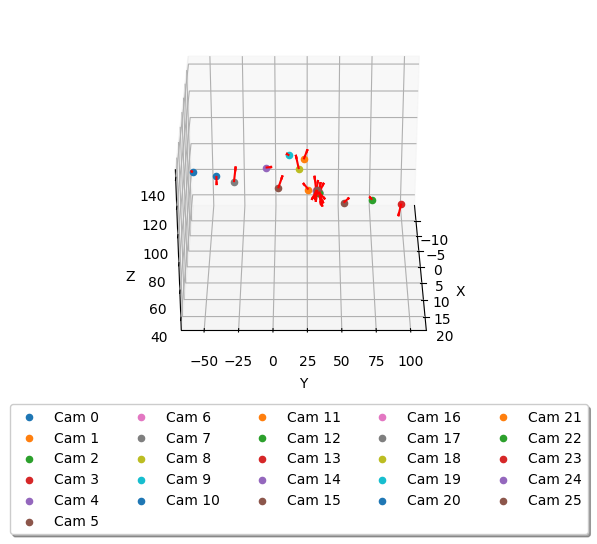

saving gif
saved gif


In [23]:
plot_poses(poses, save=True)

In [24]:
# display the gif in the notebook
from IPython.display import Image
Image(url='camera_trajectory.gif')